# Michał Szczurek lab 6

In [1]:
from collections import deque
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from timeit import timeit
import random, string

  ### 1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego

In [2]:
class Node:
    def __init__(self, char, parent, node_id,  accepting):
        self.children = {}
        self.accepting = accepting
        self.char = char
        self.id = node_id
        self.parent = parent
        self.fail_link = None
        
    def add_child(self, char):
        d[char] = Node(char)
        
    def has_child(self, char):
        return char in self.children
    
    def __str__(self):
        return str(self.char) + " " + str(self.id) + " " + str(self.accepting)

In [3]:
class Automaton:
    
    def __init__(self, patterns):
        self.root = Node("$", None, 0, None)
        self.next_id = 1
        self.pattern_dict = {} # to store patterns ids
        self.patterns = patterns
        for i, p in enumerate(patterns):
            self.add(i, p)
        self.add_fail_links()
        self.transform()
        
    def add(self, index, text):
        i = 0
        node = self.root
        while i < len(text) and node.has_child(text[i]):
            node = node.children[text[i]]
            i += 1 
        while i < len(text):
            node.children[text[i]] = Node(text[i], node, self.next_id, index if i == len(text) - 1 else None)
            if i == len(text) - 1:
                self.pattern_dict[text] = index
            node = node.children[text[i]]
            i += 1
            self.next_id +=1

    
    def add_fail_links(self):
        que = deque()
        for (key, node) in self.root.children.items():
            que.append(node)
            
        # first level fail links
        while len(que) > 0:         
            curr = que.popleft()
            if curr.parent is not self.root:
                break
            for node in curr.children.values():
                que.append(node)
            curr.fail_link = self.root
        else: # while's else - Trie has only 1 level 
            curr = None
        
        # other fail links
        while curr:
            # add children for later
            for node in curr.children.values():
                que.append(node)
            
            # build fail link
            char = curr.char
            prev = curr.parent.fail_link

            while char not in prev.children and prev is not self.root:
                prev = prev.fail_link
            # "joker" from root case
            if prev is self.root and char not in self.root.children:
                curr.fail_link = self.root
            else: 
                curr.fail_link = prev.children[char]

            if len(que) > 0:
                curr = que.popleft()
            else:
                curr = None
                
                
    def transform(self):
        """Takes tree with fail links and returns tree with 'shortcut' edges"""      
        que = deque()
        for node in self.root.children.values():
            que.append(node)  
        while len(que) > 0:     
            curr = que.popleft()
            for node in curr.children.values():
                que.append(node)
            for char, child in curr.fail_link.children.items():
                if char not in curr.children:
                    curr.children[char] = child

    def search(self, text):
        res = [-1 for _ in text]
        state = self.root
        for i, char in enumerate(text):
            if char not in state.children:
                state = self.root
            else:
                state = state.children[char]
                if state.accepting != None:
                    res[i] = state.accepting
        return res        

In [4]:
def search_2d(text, patterns):
    """Returns coordinates of lower right symbol of pattern"""
    pattern_set = set(patterns)
    automaton_1d = Automaton(pattern_set)
    res_1d = [automaton_1d.search(line) for line in text]
    res_1d = np.array(res_1d).transpose()
    pattern = tuple([automaton_1d.pattern_dict[p] for p in patterns]) # pattern made of patterns using ids
    automaton_2d = Automaton([pattern])
    res_2d = [automaton_2d.search(line) for line in res_1d]
    res = []
    for i in range(len(res_2d)):
        for j in range(len(res_2d[i])):
            if res_2d[i][j] != -1:
                res.append((j, i))
    return res

###  2. Znajdź w załączonym pliku "haystack.txt" wszyskie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach. Zwróć uwagę, na nierówną długość linii w pliku.

Funkcja dodająca do tekstu meta-znaki, tak by tekst był prostokątny

In [5]:
def parse_text(text, null_symbol='$'):
    max_len = 0
    for l in text:
        max_len = max(max_len, len(l))
    res = []
    for line in text:
        res.append(line + str((max_len - len(line)) * null_symbol))
    return res

In [6]:
with open("haystack.txt", 'r', encoding='utf-8') as file:
    text = file.readlines()

Wyszukanie sytuacji z polecenia

In [7]:
letters = set()
for line in text:
    for c in line:
        letters.add(c)

total = 0
letters = sorted(letters)
for letter in letters:
    res = search_2d(parse_text(text), [letter, letter])
    print(f"{repr(letter)} Liczba sytuacji: {len(res)} : {res}")
    total += len(res)
print(f"W sumie {total} sytuacji")

'\n' Liczba sytuacji: 1 : [(36, 79)]
' ' Liczba sytuacji: 158 : [(28, 1), (38, 1), (63, 1), (2, 2), (3, 2), (60, 2), (61, 2), (20, 3), (21, 3), (28, 3), (29, 3), (38, 3), (28, 5), (38, 5), (5, 7), (6, 7), (11, 7), (38, 7), (39, 7), (58, 7), (25, 8), (34, 8), (41, 8), (56, 8), (6, 9), (1, 10), (2, 10), (53, 10), (11, 11), (16, 11), (21, 11), (47, 12), (58, 12), (23, 13), (45, 13), (64, 13), (60, 14), (32, 15), (33, 15), (41, 15), (42, 15), (62, 15), (25, 16), (69, 16), (70, 16), (33, 17), (61, 18), (33, 19), (23, 20), (24, 20), (25, 20), (46, 20), (59, 20), (52, 21), (57, 21), (23, 22), (81, 22), (31, 23), (48, 23), (49, 23), (24, 24), (25, 24), (77, 24), (9, 25), (38, 26), (48, 26), (71, 26), (80, 26), (1, 27), (82, 27), (31, 29), (54, 29), (57, 29), (63, 29), (80, 29), (23, 30), (64, 31), (19, 32), (46, 32), (47, 32), (55, 32), (72, 32), (36, 33), (42, 33), (43, 33), (58, 33), (2, 34), (55, 34), (44, 35), (45, 35), (49, 35), (55, 36), (24, 38), (21, 39), (72, 40), (4, 41), (23, 42), (

### 3. Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji.

In [8]:
search_2d(parse_text(text), ['th', 'th'])

[]

In [9]:
search_2d(parse_text(text), ['t h', 't h'])

[(38, 2)]

 ### 4. Wybierz przynajmniej 3 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png"

Główna funkcja realizująca polecenie

In [10]:
def search_image(letter_img, source_img, print_positions=False):
    # We want immutable type to use dicts later on
    letter = []
    for line in letter_img:
        letter.append(tuple(line))
    res =  search_2d(source_img, letter)
    if print_positions:
        print(f"Znaleziono {len(res)} dopasowań na pozycjach {res}")
    else:
        print(f"Znaleziono {len(res)} dopasowań")

Funkcja wyszukująca wzorzec zw tekście (.txt) weryfikująca poprawność wyszukiwania obrazów

In [11]:
def get_pattern_count(text, pattern):
    res = len(search_2d(text, [pattern]))
    print("Całkowita liczba dopasowań:", res )

Wczytanie obrazu

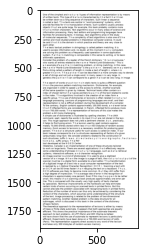

In [12]:
source_img = cv2.imread("haystack.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(source_img ,  cmap='gray')
plt.show()

Realizacja polecenia

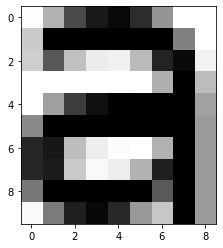

In [13]:
pattern_a = source_img[37:47,263:272]
plt.imshow(pattern_a ,  cmap='gray')
plt.show()

In [14]:
search_image(pattern_a, source_img)

Znaleziono 397 dopasowań


In [15]:
get_pattern_count(text, 'a')

Całkowita liczba dopasowań: 397


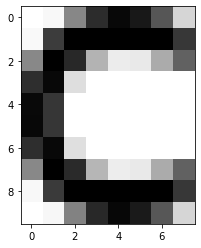

In [16]:
pattern_c = source_img[213:223,165:173]
plt.imshow(pattern_c ,  cmap='gray')
plt.show()

In [17]:
search_image(pattern_c, source_img)

Znaleziono 213 dopasowań


In [18]:
get_pattern_count(text, 'c')

Całkowita liczba dopasowań: 213


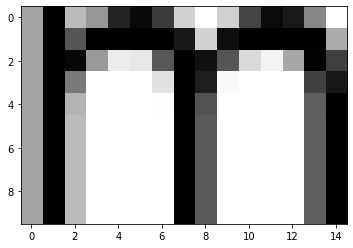

In [19]:
pattern_m = source_img[257:267,133:148]
plt.imshow(pattern_m ,  cmap='gray')
plt.show()

In [20]:
search_image(pattern_m, source_img)

Znaleziono 131 dopasowań


In [21]:
get_pattern_count(text, 'm')

Całkowita liczba dopasowań: 131


###  5. Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png.

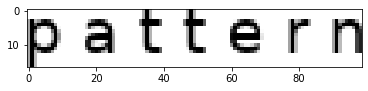

In [22]:
pattern_long = source_img[474:491,184:283]
plt.imshow(pattern_long ,  cmap='gray')
plt.show()

In [23]:
search_image(pattern_long, source_img)

Znaleziono 5 dopasowań


In [24]:
get_pattern_count(text, 'p a t t e r n')

Całkowita liczba dopasowań: 5


 ### 6. Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca

In [25]:
def measure_time(text, start=5, stop=100, step=5):
    create_times = []
    search_times = []
    lens = [i for i in range(start, stop + step, step)]
    for i in lens:
        pattern = ''.join(random.choice(string.ascii_lowercase + string.ascii_uppercase) for _ in range(i))
        automaton = Automaton([pattern])
        create = lambda: Automaton(pattern)
        search = lambda: automaton.search(text)
        create_times.append(timeit(create, number = 5000))
        search_times.append(timeit(search, number = 5000))
        
    plt.plot(lens, create_times, label="Czas budowania automatu (*5000)")
    plt.plot(lens, search_times, label="Czas wyszukiwania wzorca (*5000)")
    plt.title("Porównanie czasu budowania automatu i wyszukiwania wzorca")
    plt.legend()
    plt.show()

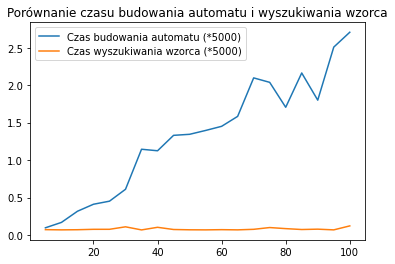

In [29]:
measure_time(text)

Test polegał na pomiarze czasu budowy i dopasowania wzorca dla wzorców o długości od 5 do 100 z krokiem 5. Wyniki wskazują na to, że całkowity czas wykonywania się algorytmu jest zdominowany przez czas potrzebny na zbudowanie automatu.

### 7. Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania

In [34]:
def measure_diffrent_files(file, pattern='1234567890qwertyuiopasdfghjklzxcvbnm', to_test = None):
    times = []
    automaton = Automaton([pattern])
    if to_test is None:
        to_test = [1, 2, 4, 8]
    for i in to_test:
        texts = []
        with open(file, 'r', encoding='utf-8') as source:
            for j in range(i):
                texts.append([])
                if j == i - 1:
                    while True:
                        line = source.readline()
                        if not line:
                            break
                        texts[-1].append(line)
                else:
                    for k in range(len(text) // i):
                        line = source.readline()
                        texts[-1].append(line)
          
        test_times = []
        for t in texts:
            search = lambda: automaton.search(t)
            test_times.append(timeit(search, number = 50000))
        times.append(test_times)
        
    print("*** Podane czasy odpowiadają 50000 wyszukiwań ***\n") 
    for i, test in enumerate(to_test):
        print(f"Wyniki po podziale pliku na {test} części")
        for j, t in enumerate(times[i]):
            print(f"Czas dla wyszukania w części {j+1}.: {t}")
        print("-----------------------------------------------------")
        print(f"Sumaryczny czas : {sum(times[i])}\n")
        

In [37]:
measure_diffrent_files("haystack.txt")

*** Podane czasy odpowiadają 50000 wyszukiwań ***

Wyniki po podziale pliku na 1 części
Czas dla wyszukania w części 1.: 0.542590699998982
-----------------------------------------------------
Sumaryczny czas : 0.542590699998982

Wyniki po podziale pliku na 2 części
Czas dla wyszukania w części 1.: 0.2822813999991922
Czas dla wyszukania w części 2.: 0.2833143999996537
-----------------------------------------------------
Sumaryczny czas : 0.5655957999988459

Wyniki po podziale pliku na 4 części
Czas dla wyszukania w części 1.: 0.15337240000008023
Czas dla wyszukania w części 2.: 0.1553607000005286
Czas dla wyszukania w części 3.: 0.15527750000001106
Czas dla wyszukania w części 4.: 0.1498740999995789
-----------------------------------------------------
Sumaryczny czas : 0.6138847000001988

Wyniki po podziale pliku na 8 części
Czas dla wyszukania w części 1.: 0.08549000000130036
Czas dla wyszukania w części 2.: 0.08841799999936484
Czas dla wyszukania w części 3.: 0.08458190000055765
Cz

Wyniki wskazują na to, że dzielenie tekstu na fragmenty, pogorszyło czas działania algorytmu.